In [1]:
%matplotlib notebook

import pims

import numpy as np

import pandas as pd

from trackpy import locate

from starfish.stack import ImageStack
from starfish.experiment import Experiment
from starfish.constants import Indices

#from starfish.pipeline.filter.mean_high_pass import MeanHighPass
#from starfish.pipeline.filter.gaussian_low_pass import GaussianLowPass

from starfish.image._filter import Filter

from sklearn.neighbors import KDTree
from collections import Counter

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def importMMStack(file_name, series=0):
    bf_reader = pims.Bioformats(file_name, series=series)
    
    # Get the image dimensions
    im_dims = bf_reader.sizes

    # Pre allocate the array
    fish_array = np.zeros((1, 1, im_dims['z'], im_dims['x'], im_dims['y']))
    nuc_array = np.zeros((1, 1, im_dims['z'], im_dims['x'], im_dims['y']))
    
    bf_reader.iter_axes = 'c'
    
    c_idx = 0
    for f in bf_reader:
        for z_idx in range(im_dims['z']):
            
            if c_idx == 0:
                nuc_array[0, 0, z_idx, :, :] = f[z_idx, :, :]
            elif c_idx == 1:
                fish_array[0, 0, z_idx, :, :] = f[z_idx, :, :]
            
        c_idx += 1
            
    IS_fish = ImageStack.from_numpy_array(fish_array.astype('uint16'))
    IS_nuc = ImageStack.from_numpy_array(nuc_array.astype('uint16'))
    
    aux_dict = {'nuclei': IS_nuc}
    
    s = Experiment.from_data(image_stack=IS_fish, aux_dict=aux_dict)
  
    return s

In [3]:
def spot_detector(image, diameter=3, minmass=2500, maxsize=5, separation=5, preprocess=False, percentile=10):
    spots_table = locate(image, diameter=diameter, minmass=minmass, 
                         maxsize=maxsize, separation=separation, preprocess=preprocess, percentile=percentile) 
    spots_table.columns = ['x', 'y', 'intensity', 'r', 'eccentricity', 'signal', 'raw_mass', 'ep']
    spots_table.index = (range(len(spots_table)))

    return spots_table

In [4]:
def assign_spots(nuc_coords_filename, spots_table, thresh):

    centroids = pd.read_csv(nuc_coords_filename)

    x_coords = centroids.Location_Center_X
    y_coords = centroids.Location_Center_Y

    coords = np.array([list(a) for a in zip(x_coords, y_coords)])

    kdt = KDTree(coords)

    spot_x_coords = spots_table.x
    spot_y_coords = spots_table.y

    spot_coords = np.array([list(a) for a in zip(spot_y_coords, spot_x_coords)])

    dist, ind = kdt.query(spot_coords, k=1)

    spot_mask = dist < thresh;

    good_spots_ind = ind[spot_mask]

    spot_counts = Counter(good_spots_ind)
    
    # Get the spots per cell
    spots_per_cell = [None] * len(spot_counts)
    for i, k in enumerate(spot_counts):
        spots_per_cell[i] = (k, spot_counts[k])

    return spots_per_cell

In [ ]:
images_df = pd.read_csv('WT_images_20180803.csv')

spots = [None] * len(images_df)

im = images_df.iloc[0]

print(im.image, im.series)

s = importMMStack(im.image)

ISP_293T_WT_TFRC_20180803_2_MMStack_Pos0.ome.tif 0


In [8]:

s_mhp = MeanHighPass(size=6, verbose=True)
s_mhp.filter(s.image)

# Perform the gaussian low pass filter
sigma=(2, 1, 1)

glp = GaussianLowPass(sigma=sigma, is_volume=True, verbose=True)
glp.filter(s.image)

#s.image.show_stack({Indices.CH: 0})

# Get a maximum intensity projection
ch0 = s.image.max_proj(Indices.Z.value)[0, 0]

81it [00:14,  5.53it/s]
1it [01:09, 69.23s/it]


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/trackpy/refine/center_of_mass.py:233: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  neighborhood = mask*image[rect]
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/trackpy/refine/center_of_mass.py:275: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  raw_neighborhood = mask*raw_image[rect]


<IPython.core.display.Javascript object>


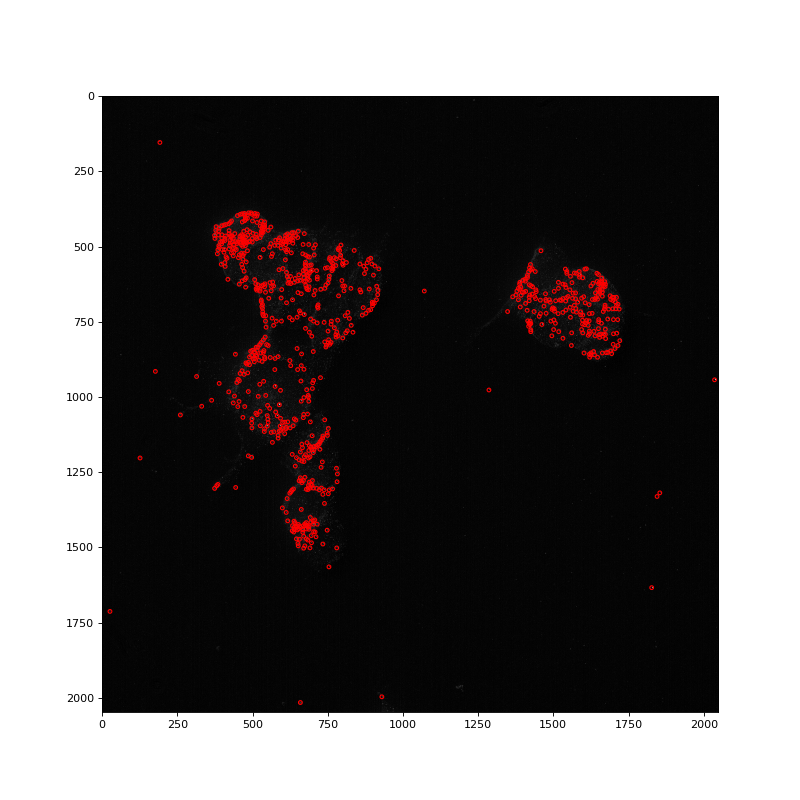

In [17]:
from matplotlib import pyplot as plt

# Find the spots
diameter = 3
minmass = 1500
maxsize = 5
separation = 5
preprocess = False
percentile = 10

spots_table = spot_detector(image=ch0, diameter=diameter, minmass=minmass, 
    maxsize=maxsize, separation=separation, preprocess=preprocess, percentile=percentile)

# plot the z-projection
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ch0, cmap=plt.cm.gray)



# draw called spots on top as red circles
# scale radius plots the red circle at scale_radius * spot radius
s.image._show_spots(spots_table, ax=plt.gca(), scale_radius=7);

In [18]:
spots_per_cell = assign_spots(im.nuc_coords, spots_table, 150)

print(spots_per_cell)

[(0, 158), (1, 62), (2, 90), (4, 131), (3, 39), (5, 62), (6, 49), (7, 32), (8, 44), (9, 19)]


In [5]:
from tqdm import tqdm

images_df = pd.read_csv('WT_images_20180803.csv')

spot_counts = [None] * len(images_df)

for idx, im in tqdm(images_df.iterrows()):
    s = importMMStack(im.image, im.series)
    s_mhp = Filter.MeanHighPass(size=6, verbose=False)
    s_mhp.run(s.image)

    # Perform the gaussian low pass filter
    sigma=(2, 1, 1)

    glp = Filter.GaussianLowPass(sigma=sigma, is_volume=True, verbose=False)
    glp.run(s.image)

    #s.image.show_stack({Indices.CH: 0})

    # Get a maximum intensity projection
    ch0 = s.image.max_proj(Indices.Z)[0, 0]
    
    # Find the spots
    diameter = 3
    minmass = 1500
    maxsize = 5
    separation = 5
    preprocess = False
    percentile = 10

    spots_table = spot_detector(image=ch0, diameter=diameter, minmass=minmass, 
        maxsize=maxsize, separation=separation, preprocess=preprocess, percentile=percentile)
    
    spots_per_cell = assign_spots(im.nuc_coords, spots_table, 150)
    
    #print(spots_per_cell)
    
    spot_counts[idx] = spots_per_cell
    

0it [00:00, ?it/s]/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/trackpy/refine/center_of_mass.py:233: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  neighborhood = mask*image[rect]
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/trackpy/refine/center_of_mass.py:275: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  raw_neighborhood = mask*raw_image[rect]
5it [16:47, 201.56s/it]


In [6]:
im_index = []
cell_index = []
n_spots = []

for idx, im in enumerate(spot_counts):
    for cell in im:
        im_index.append(idx)
        cell_index.append(cell[0])
        n_spots.append(cell[1])
        
        
df = pd.DataFrame(data={'image': im_index, 'cell': cell_index, 'tfrc_counts': n_spots})

df.to_csv('TFRC_WT_FISH.csv')

<IPython.core.display.Javascript object>


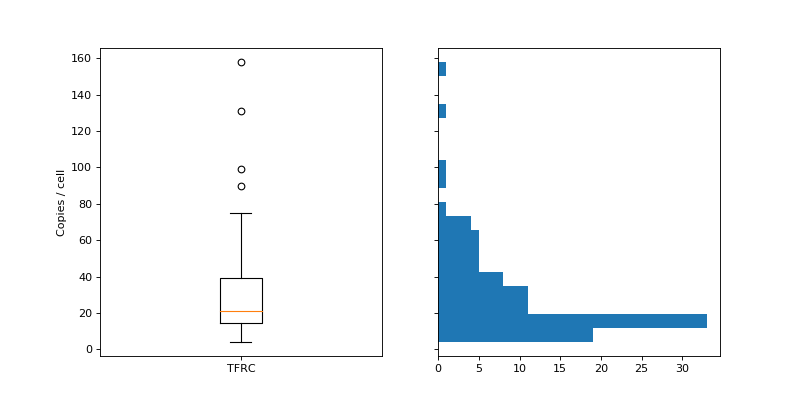

In [7]:
from matplotlib import pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

ax1.boxplot(n_spots, labels=['TFRC']);

#ax1.set_ylim((0,50));
ax1.set_ylabel('Copies / cell');

ax2.hist(n_spots, bins=20, orientation='horizontal');

